# 🌎 NCEP Weather Data Exploration & Graph Representation

This notebook explores the NCEP Reanalysis dataset using pre-processed data to avoid redundant computations. We'll visualize weather variables spatially and temporally, examine their graph representations, and apply spherical harmonics analysis.

In [38]:
# 📦 Import required packages
import sys
sys.path.append("../")

import os
import torch
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from data.preprocess import load_ncep_data, visualize_graph
from data.spectral_transform import *

## 📂 Load Pre-processed Dataset

Since we already have the processed dataset saved, we'll load it directly and extract the raw NCEP data for visualization.

In [10]:
# Load pre-processed temporal dataset
base_path = "/Users/anuranjani/Desktop/my_projects/spectral-gnn-for-weather-analysis"
processed_dir = os.path.join(base_path, "data/processed")
processed_dataset_path = os.path.join(processed_dir, "ncep_temporal_dataset.pt")
temporal_dataset = torch.load(processed_dataset_path, weights_only=False)
print(f"Loaded dataset with {len(temporal_dataset)} samples")

# Extract a sample for inspection
sample = temporal_dataset[0]
print("\nSample structure:")
print(f"  History: {len(sample['history'])} time steps")
print(f"  History graph: {sample['history'][0].x.shape}")
print(f"  Target: {len(sample['target'])} time steps")
print(f"  Target graph: {sample['target'][0].x.shape}")
print(f"  Sample timestamp: {sample['timestamp']}")

Loaded dataset with 1459 samples

Sample structure:
  History: 5 time steps
  History graph: torch.Size([48096, 4])
  Target: 1 time steps
  Target graph: torch.Size([48096, 4])
  Sample timestamp: 2024-01-02T06:00:00.000000000


In [11]:
# Load original NCEP data for visualization (but don't repeat processing)
data_dir = "../data/raw"
variables = ['air', 'uwnd', 'vwnd', 'slp']
ds = load_ncep_data(data_dir, variables=['air.2m.gauss.2024', 'uwnd.10m.gauss.2024', 'vwnd.10m.gauss.2024', 'slp.2024'])

In [12]:
# 📝 Print dataset summary
print(f"Time coverage: {ds.time.values[0]} to {ds.time.values[-1]}")
print(f"Time steps: {len(ds.time)}")
print(f"Spatial resolution: {len(ds.lat)} x {len(ds.lon)}")
print(f"Available variables: {list(ds.data_vars)}")

Time coverage: 2024-01-01T00:00:00.000000000 to 2024-12-31T18:00:00.000000000
Time steps: 1464
Spatial resolution: 167 x 288
Available variables: ['air', 'uwnd', 'vwnd', 'slp']


## 🗺️ Geographic Visualization of NCEP Variables

In [13]:
def plot_ncep_map(ds, variable, time_idx=0, title=None):
    plt.figure(figsize=(15, 8))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    data = ds[variable].isel(time=time_idx)
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False)
    
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
    if hasattr(data, 'units'):
        cbar.set_label(f"{variable} [{data.units}]")
    else:
        cbar.set_label(f"{variable}")
    
    plt.title(title or f"{variable} at {str(data.time.values)}")
    plt.tight_layout()
    return plt.gcf()

/Users/anuranjani/Desktop/my_projects/spectral-gnn-for-weather-analysis/.venv/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/anuranjani/Desktop/my_projects/spectral-gnn-for-weather-analysis/.venv/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


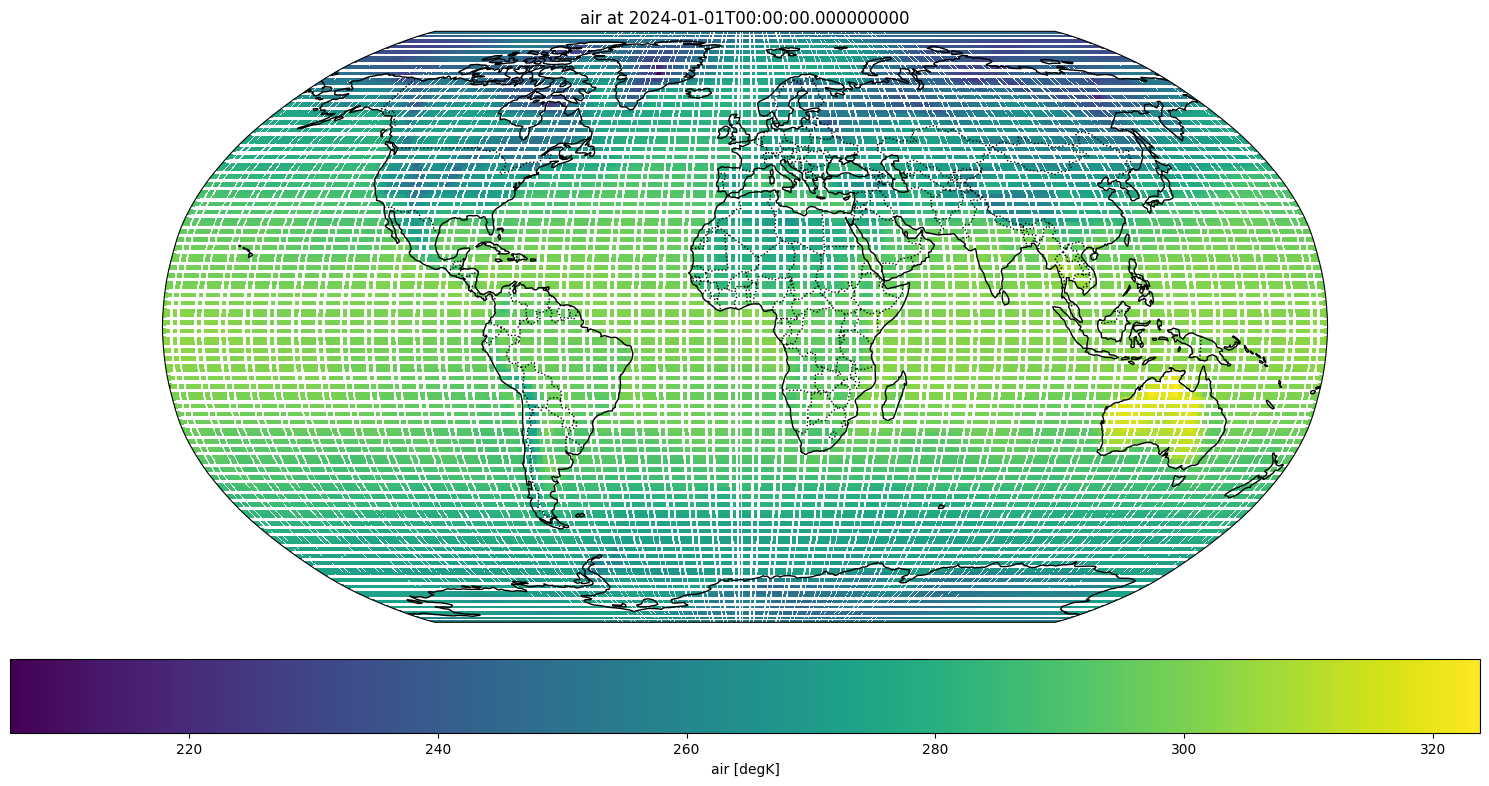

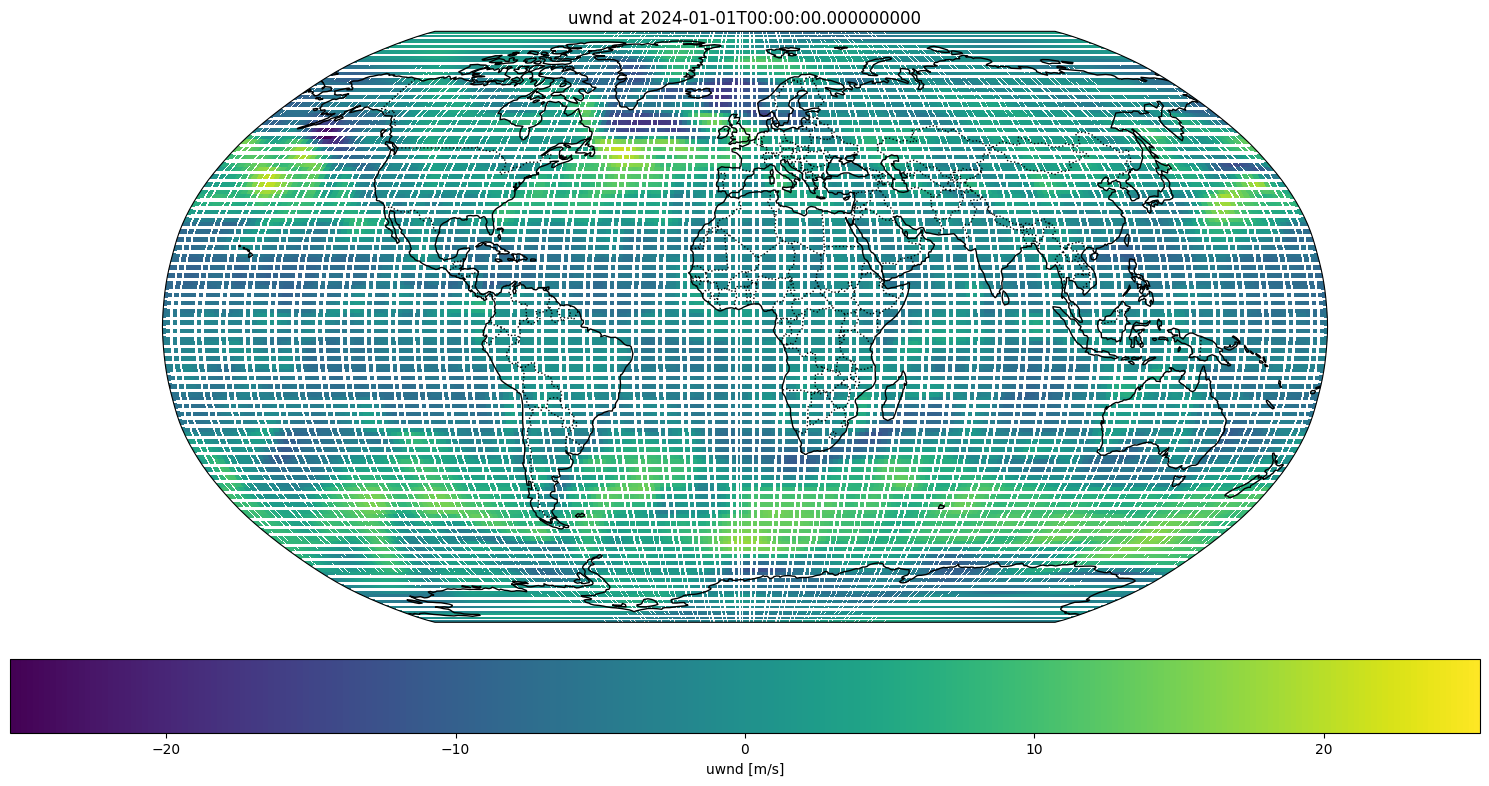

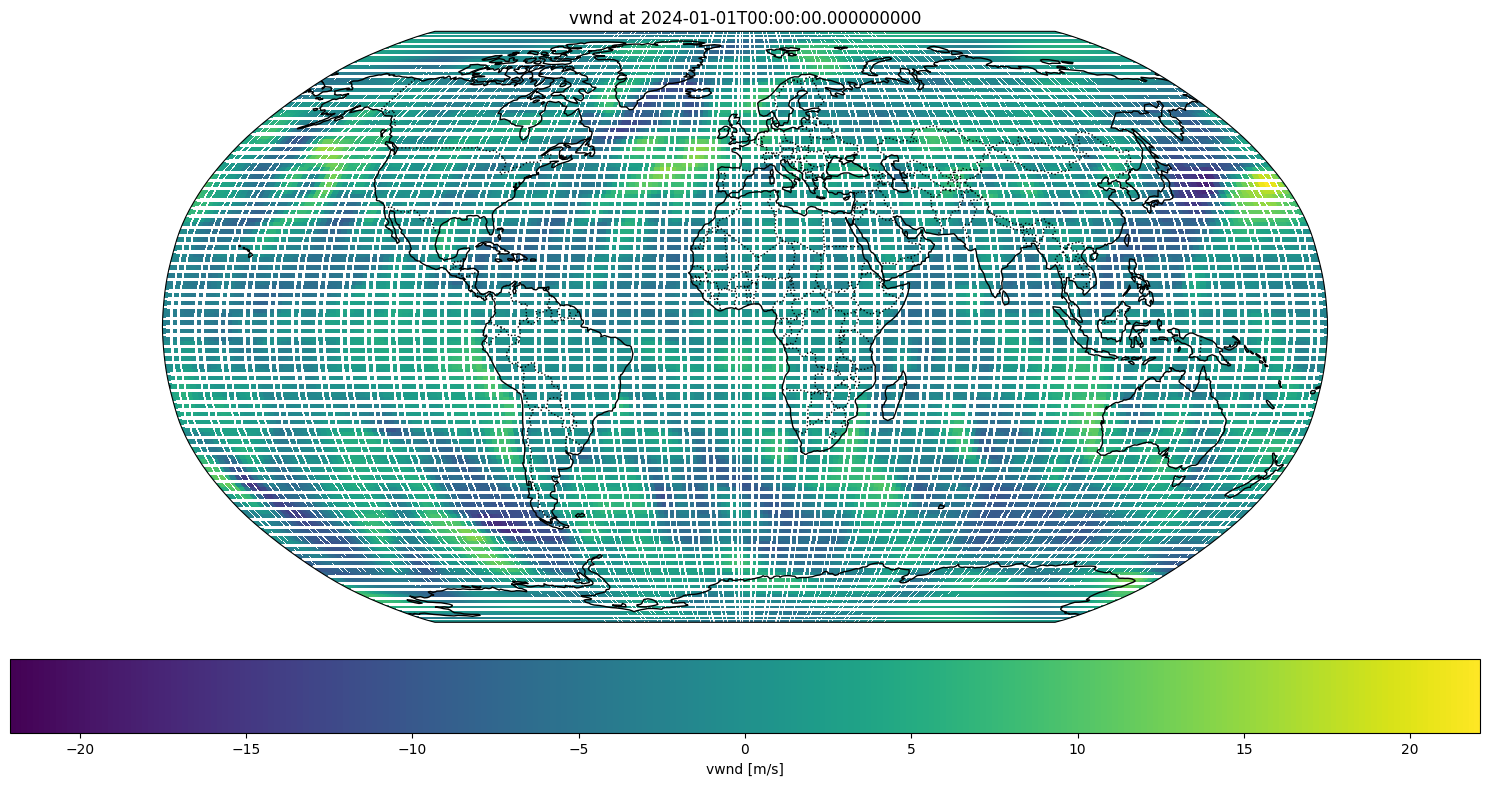

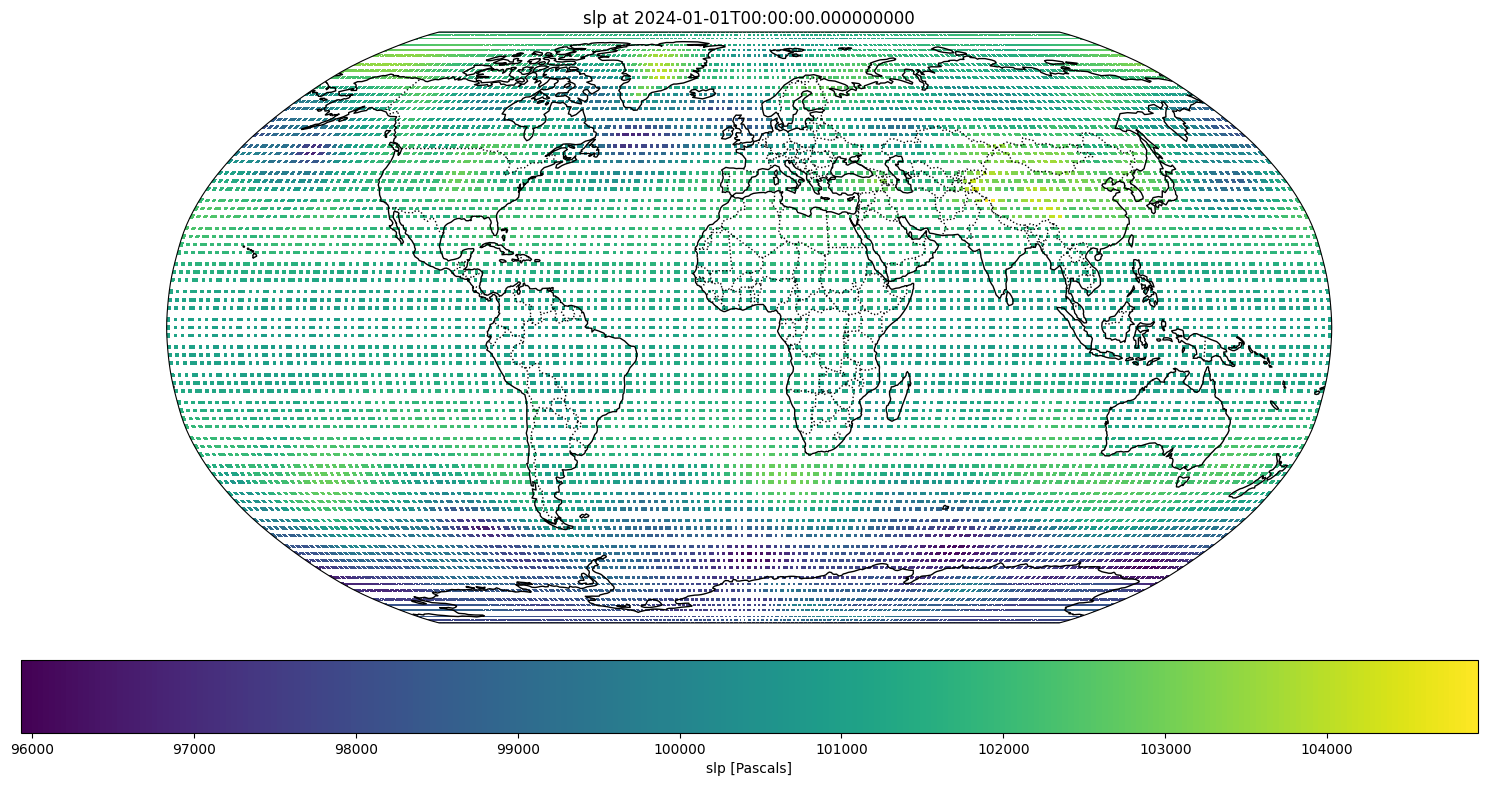

In [14]:
# Visualize the first timestep of each variable
time_idx = 0
for var in ds.data_vars:
    plot_ncep_map(ds, var, time_idx=time_idx)
    plt.show()

## 🌐 Graph Representation Analysis

Analyzing the properties of our pre-processed graph representations

In [15]:
# Extract a graph from our pre-processed dataset
graph = sample['history'][0]  # First history graph from first sample
print(f"Nodes: {graph.x.shape[0]}, Features per node: {graph.x.shape[1]}")
print(f"Edges: {graph.edge_index.shape[1]}")
print(f"Average node degree: {graph.edge_index.shape[1] / graph.x.shape[0]:.2f}")

Nodes: 48096, Features per node: 4
Edges: 311896
Average node degree: 6.48


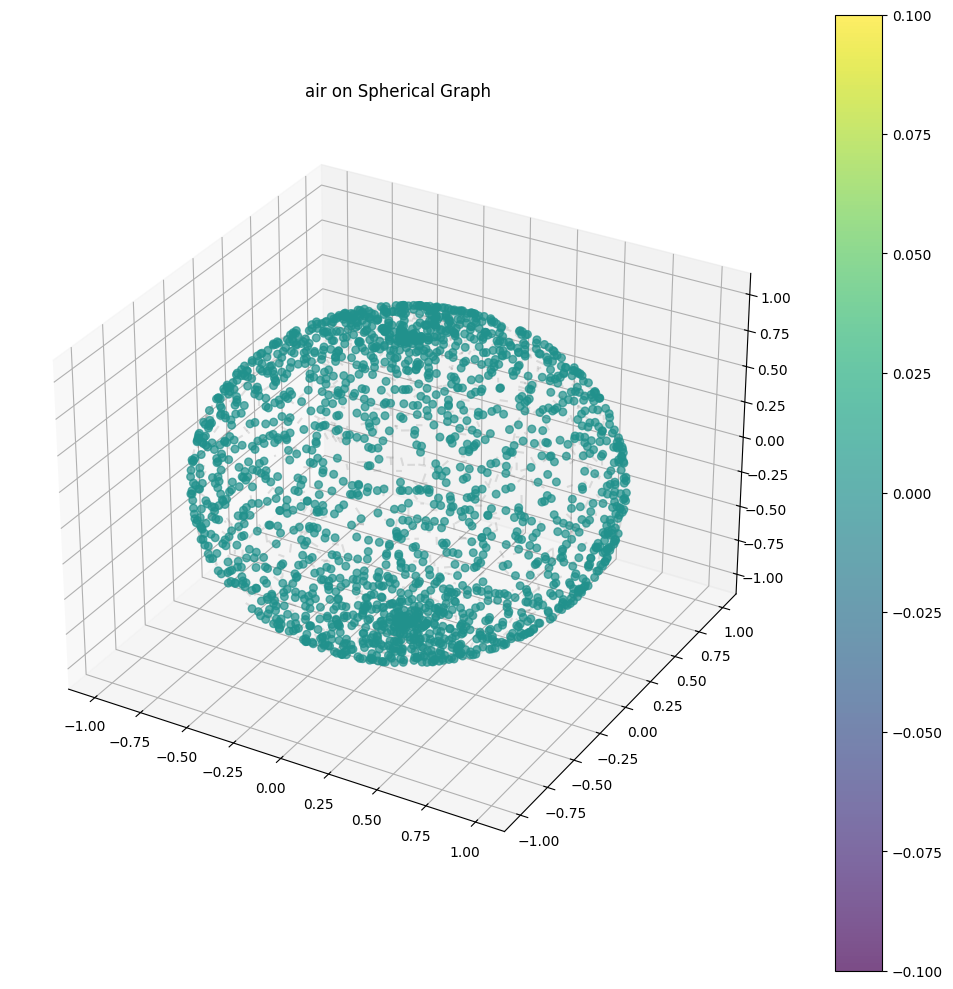

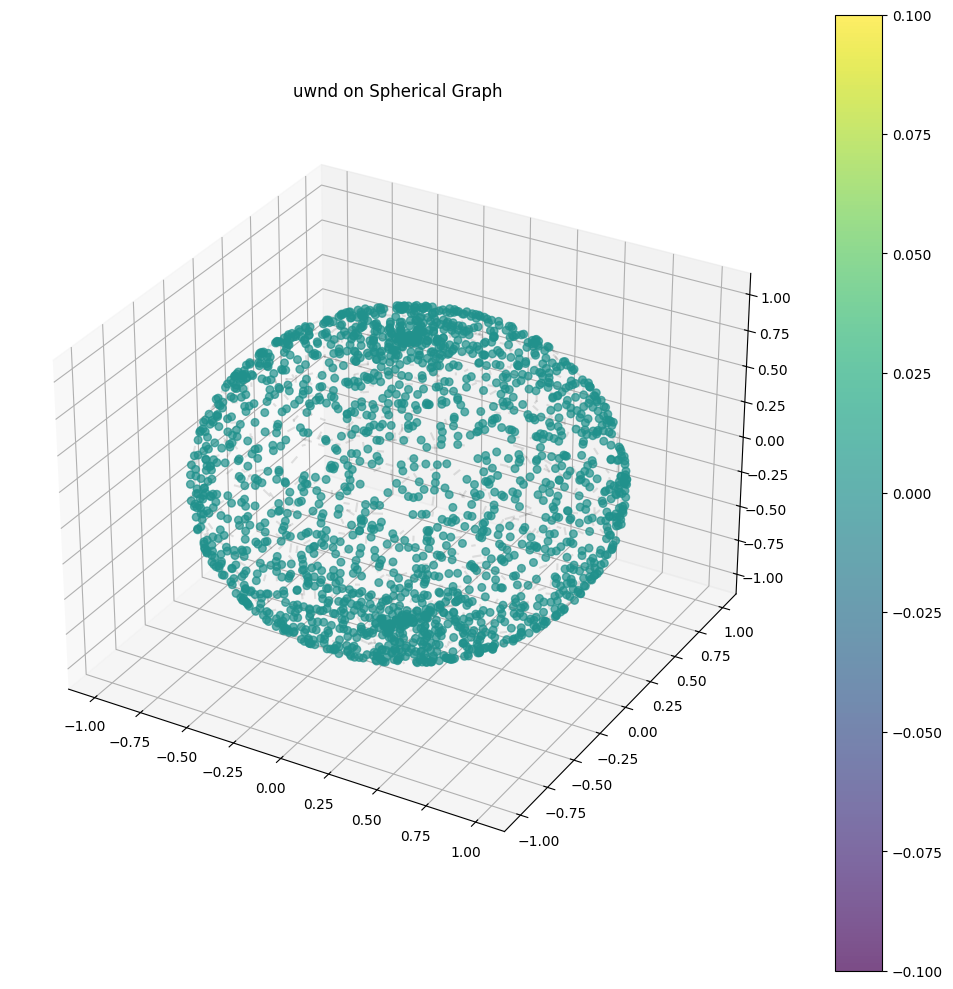

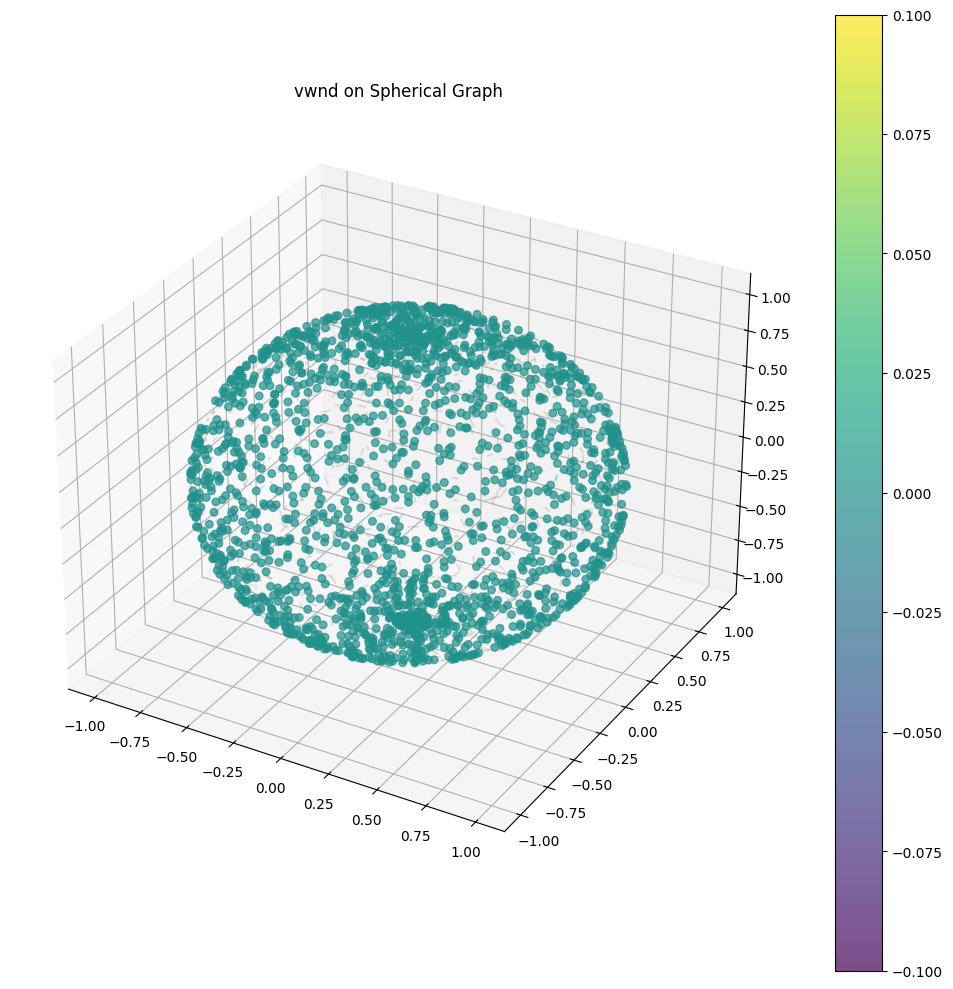

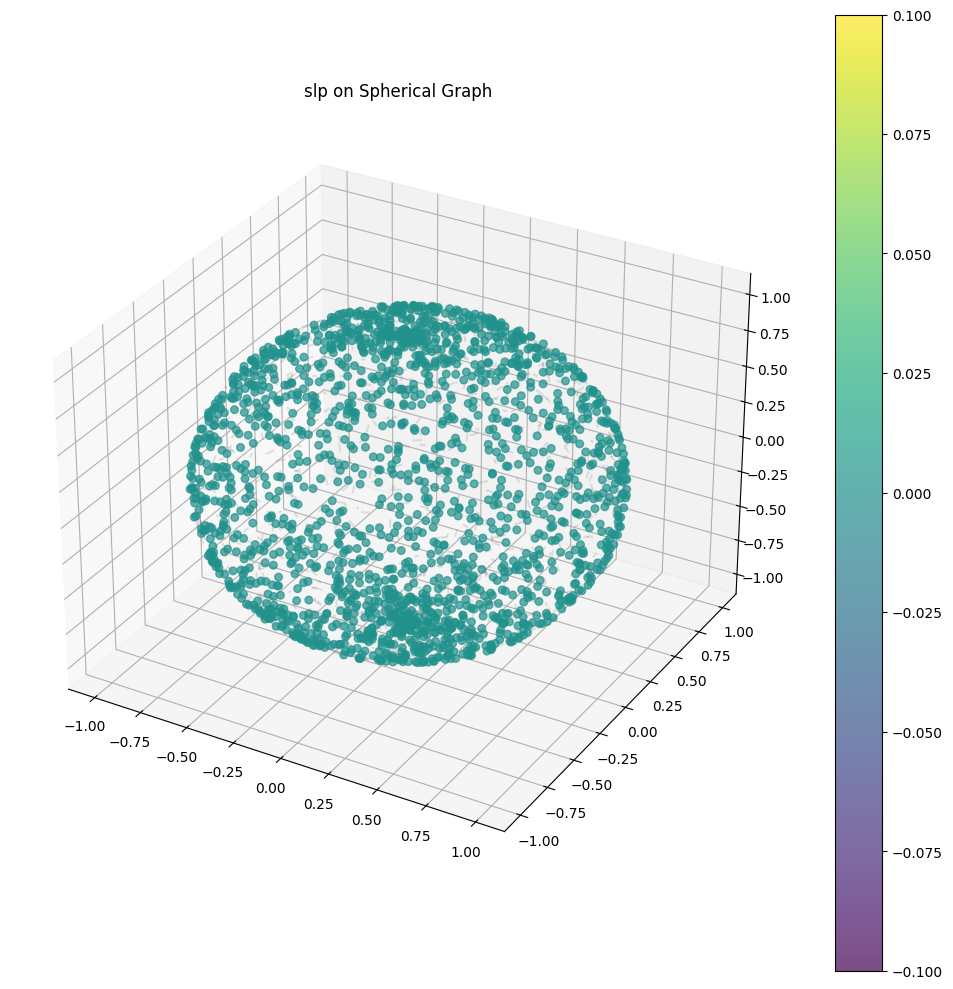

In [16]:
# Visualize each variable on the graph
for i, var in enumerate(variables):
    fig = visualize_graph(graph, variable_idx=i, title=f"{var} on Spherical Graph", max_edges=1000)
    plt.show()

## 🧭 Spherical Harmonic Analysis

Let's analyze the spherical harmonic decomposition with a reasonable lmax value

In [18]:
print(f"data.x shape: {graph.x.shape}")
print(f"data.pos shape: {graph.pos.shape}")
print(f"Number of nodes: {graph.num_nodes}")

data.x shape: torch.Size([48096, 4])
data.pos shape: torch.Size([48096, 3])
Number of nodes: 48096


In [28]:
print(f"Total nodes: {graph.num_nodes}")
for test_nlat in range(1, 500):
    if graph.num_nodes % test_nlat == 0:
        test_nlon = graph.num_nodes // test_nlat
        print(f"Possible grid: ({test_nlat}, {test_nlon})")

Total nodes: 48096
Possible grid: (1, 48096)
Possible grid: (2, 24048)
Possible grid: (3, 16032)
Possible grid: (4, 12024)
Possible grid: (6, 8016)
Possible grid: (8, 6012)
Possible grid: (9, 5344)
Possible grid: (12, 4008)
Possible grid: (16, 3006)
Possible grid: (18, 2672)
Possible grid: (24, 2004)
Possible grid: (32, 1503)
Possible grid: (36, 1336)
Possible grid: (48, 1002)
Possible grid: (72, 668)
Possible grid: (96, 501)
Possible grid: (144, 334)
Possible grid: (167, 288)
Possible grid: (288, 167)
Possible grid: (334, 144)


In [31]:
nlat, nlon = 288, 167
assert nlat * nlon == graph.num_nodes

features = graph.x.reshape(nlat, nlon, -1)  # this should now work

print("Reshape successful!")


Reshape successful!


In [42]:
import importlib
import data.spectral_transform as st  # or however you imported it

importlib.reload(st)

<module 'data.spectral_transform' from '/Users/anuranjani/Desktop/my_projects/spectral-gnn-for-weather-analysis/notebooks/../data/spectral_transform.py'>

In [51]:
print("Original graph.x stats:")
for i, var in enumerate(variables):
    print(f"{var}: min={graph.x[:, i].min().item():.4f}, max={graph.x[:, i].max().item():.4f}, mean={graph.x[:, i].mean().item():.4f}")


Original graph.x stats:
air: min=0.0000, max=0.0000, mean=0.0000
uwnd: min=0.0000, max=0.0000, mean=0.0000
vwnd: min=0.0000, max=0.0000, mean=0.0000
slp: min=0.0000, max=0.0000, mean=0.0000


In [49]:
x, y, z = graph.pos[:, 0], graph.pos[:, 1], graph.pos[:, 2]
r = torch.sqrt(x**2 + y**2 + z**2)
theta = torch.acos(z / r)
phi = torch.atan2(y, x)

theta_rounded = torch.round(theta * 1e4) / 1e4
phi_rounded = torch.round(phi * 1e4) / 1e4
sorted_indices = torch.from_numpy(np.lexsort((phi_rounded.numpy(), theta_rounded.numpy())))

x_sorted = graph.x[sorted_indices]

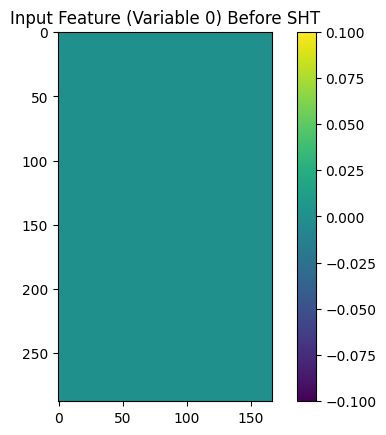

In [50]:
# Visualize original signal (e.g., variable 0) after reshaping
signal_0 = x_sorted[:, 0].reshape(nlat, nlon)
plt.imshow(signal_0.numpy(), cmap='viridis')
plt.colorbar()
plt.title("Input Feature (Variable 0) Before SHT")
plt.show()


In [47]:
sh_coeffs = st.spherical_harmonic_transform(graph, lmax=10, nlat=288, nlon=167)
lmax=10
print(f"Spherical harmonic coefficients shape: {sh_coeffs.shape}")


Spherical harmonic coefficients shape: torch.Size([10, 84, 4])


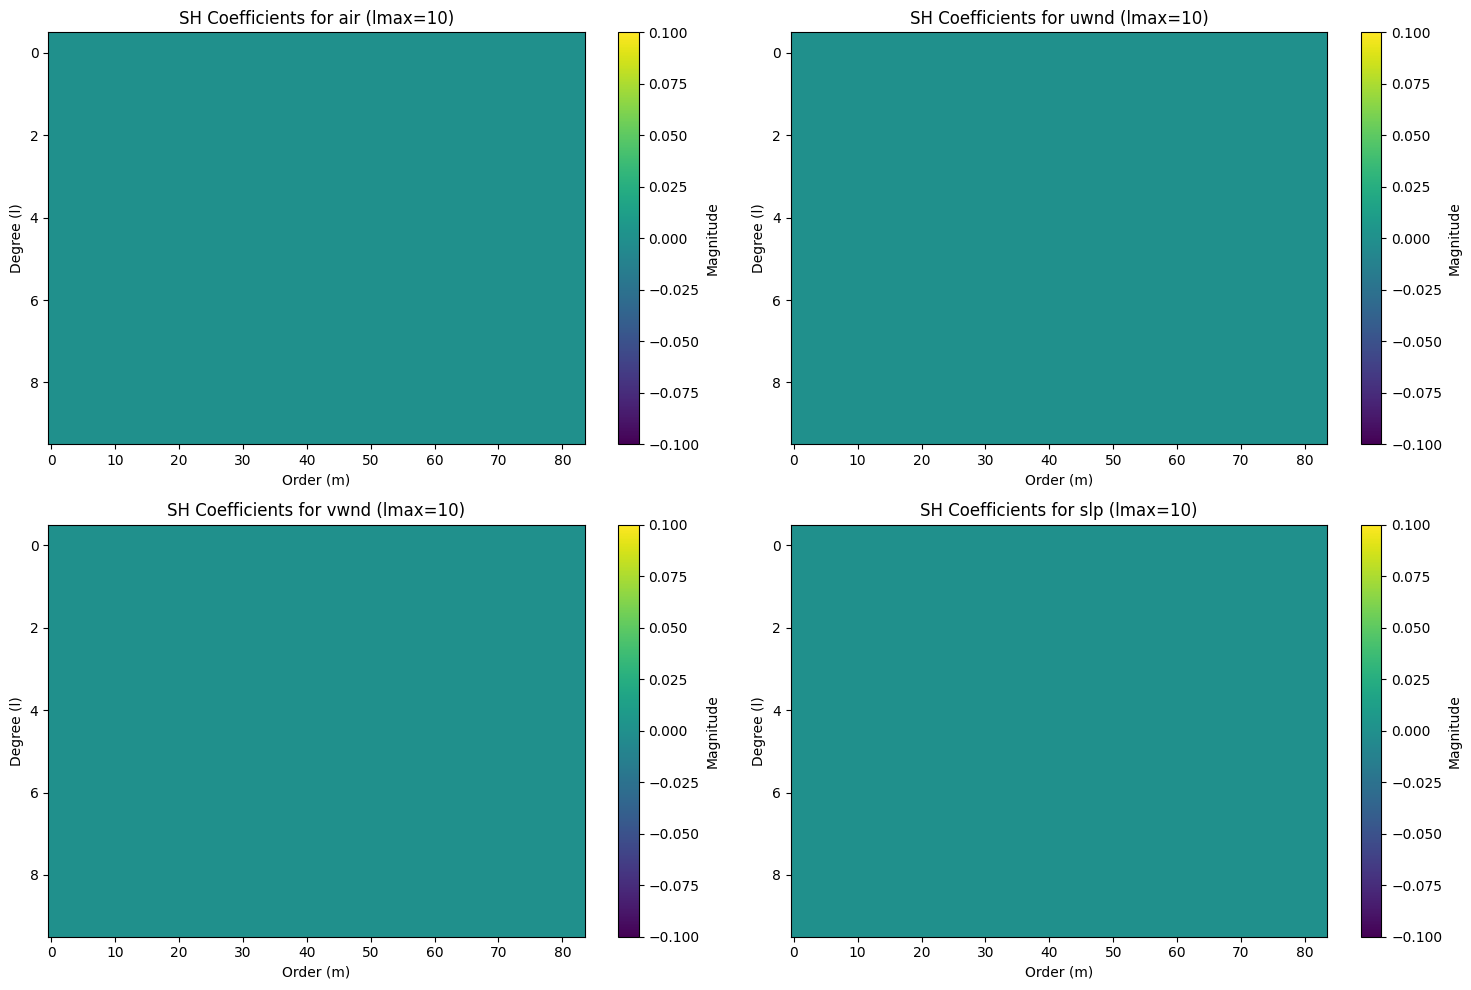

In [48]:
# Visualize the spherical harmonic coefficients for each variable
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    plt.imshow(sh_coeffs[..., i].abs().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar(label='Magnitude')
    plt.title(f'SH Coefficients for {var} (lmax={lmax})')
    plt.xlabel('Order (m)')
    plt.ylabel('Degree (l)')
plt.tight_layout()
plt.show()

## 📈 Temporal Analysis of Graph Features

In [45]:
# Extract temporal statistics from our pre-processed dataset
# Let's look at the evolution of feature statistics over time

def extract_graph_stats(sample_list, num_features):
    stats = {
        'mean': np.zeros((len(sample_list), num_features)),
        'std': np.zeros((len(sample_list), num_features)),
        'min': np.zeros((len(sample_list), num_features)),
        'max': np.zeros((len(sample_list), num_features))
    }
    
    for i, sample in enumerate(sample_list):
        # Extract statistics for each feature
        for j in range(num_features):
            feature_values = sample.x[:, j].numpy()
            stats['mean'][i, j] = np.mean(feature_values)
            stats['std'][i, j] = np.std(feature_values)
            stats['min'][i, j] = np.min(feature_values)
            stats['max'][i, j] = np.max(feature_values)
            
    return stats

# Analyze first 10 samples (or fewer if dataset is smaller)
num_samples = min(10, len(temporal_dataset))
all_history_graphs = []

for i in range(num_samples):
    all_history_graphs.extend(temporal_dataset[i]['history'])

num_features = all_history_graphs[0].x.shape[1]
temporal_stats = extract_graph_stats(all_history_graphs, num_features)

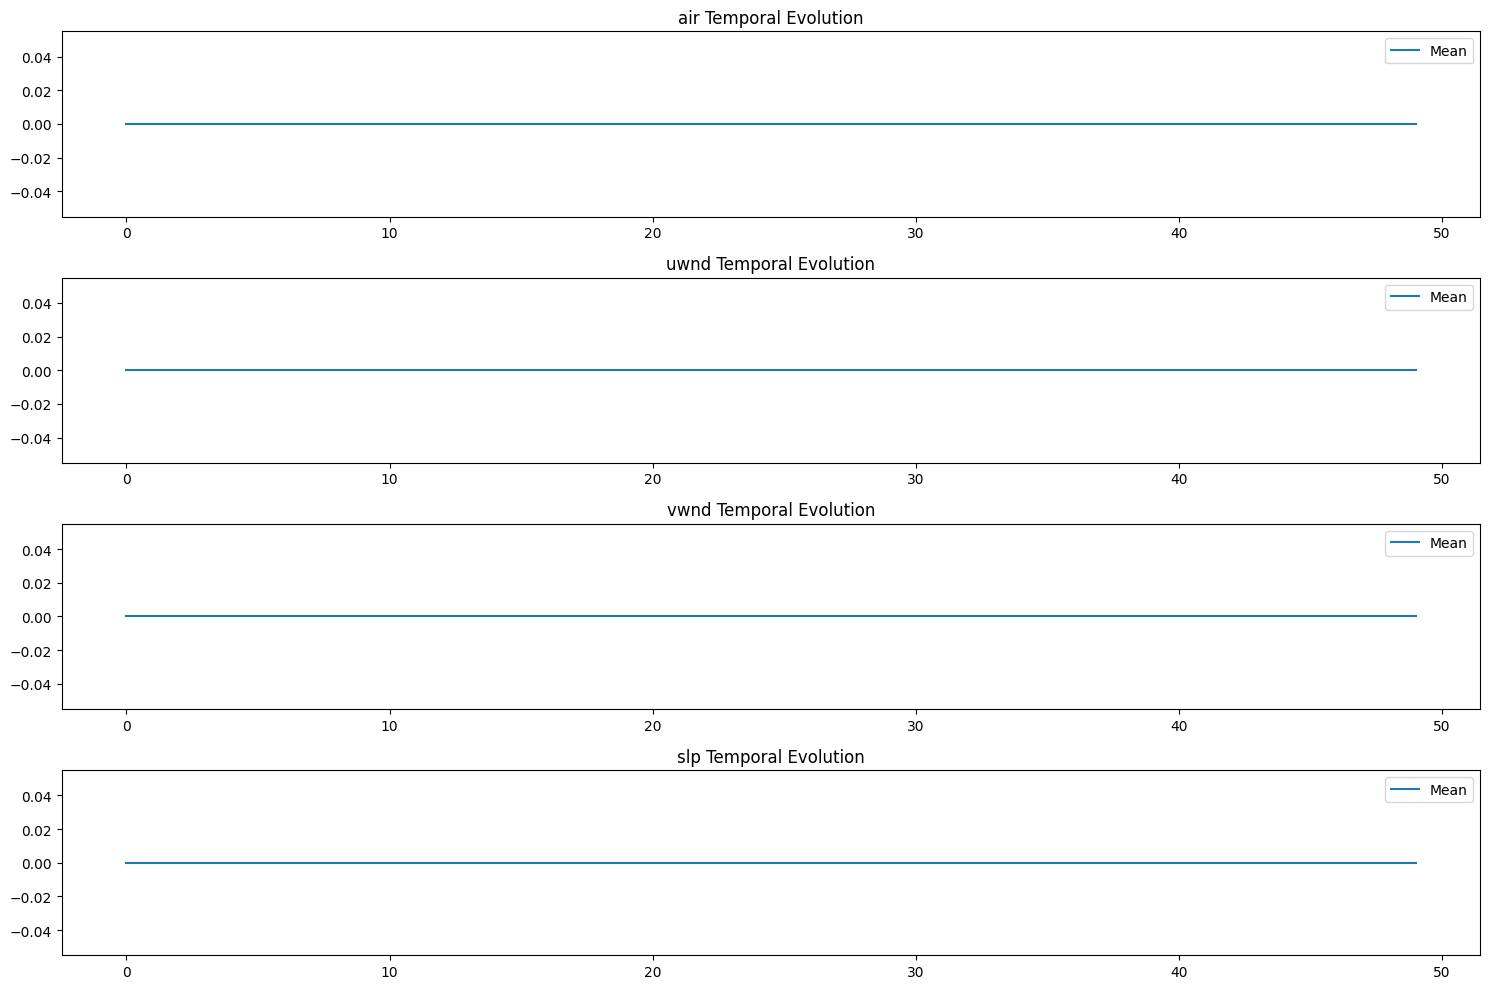

In [46]:
# Visualize temporal evolution of feature statistics
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i+1)
    plt.plot(temporal_stats['mean'][:, i], label='Mean')
    plt.fill_between(
        range(len(temporal_stats['mean'][:, i])),
        temporal_stats['mean'][:, i] - temporal_stats['std'][:, i],
        temporal_stats['mean'][:, i] + temporal_stats['std'][:, i],
        alpha=0.3
    )
    plt.title(f"{var} Temporal Evolution")
    plt.legend()
    
plt.tight_layout()
plt.show()

## 📊 Statistical Analysis of Graph Data

In [ ]:
# Analyze the distribution of node features in a sample graph
sample_graph = sample['history'][0]
feature_data = {variables[i]: sample_graph.x[:, i].numpy() for i in range(len(variables))}
feature_df = pd.DataFrame(feature_data)

# Generate summary statistics
stats_summary = feature_df.describe()
stats_summary

In [ ]:
# Plot feature distributions
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    plt.hist(feature_df[var], bins=50, alpha=0.7)
    plt.title(f"{var} Distribution")
    plt.axvline(feature_df[var].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
    plt.legend()
plt.tight_layout()
plt.show()

## 🔗 Correlation Between Variables

In [ ]:
# Calculate correlation matrix from the graph data
correlation = feature_df.corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(variables)), variables)
plt.yticks(range(len(variables)), variables)

for i in range(len(variables)):
    for j in range(len(variables)):
        plt.text(j, i, f"{correlation.iloc[i, j]:.2f}", 
                 ha="center", va="center", 
                 color="black" if abs(correlation.iloc[i, j]) < 0.7 else "white")
        
plt.title('Correlation Matrix of NCEP Variables')
plt.tight_layout()
plt.show()

## 🔄 Analyzing Temporal Sequences in the Dataset

In [ ]:
# Extract history and target from a sample to analyze forecasting patterns
sample_idx = 0
sample = temporal_dataset[sample_idx]
history_features = np.stack([graph.x.numpy() for graph in sample['history']])
target_features = np.stack([graph.x.numpy() for graph in sample['target']])

print(f"History shape: {history_features.shape}")
print(f"Target shape: {target_features.shape}")

In [ ]:
# Visualize the temporal evolution for a specific node
node_idx = 0  # Just look at the first node as an example

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(len(variables), 1, i+1)
    
    # Plot history
    history_steps = range(len(sample['history']))
    plt.plot(history_steps, history_features[:, node_idx, i], 'b-o', label='History')
    
    # Plot target (forecast)
    target_steps = range(len(sample['history']), len(sample['history']) + len(sample['target']))
    plt.plot(target_steps, target_features[:, node_idx, i], 'r-o', label='Target')
    
    plt.title(f"{var} - Node {node_idx}")
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()
    
plt.tight_layout()
plt.show()

## 🧪 Spectral GNN Feature Analysis

Analyze the spectral features that will be used for SFNO model training

In [ ]:
# Compare the spectral decomposition of history vs target
history_graph = sample['history'][-1]  # Last history timestep
target_graph = sample['target'][0]     # First target timestep

history_sh = spherical_harmonic_transform(history_graph, lmax=10)
target_sh = spherical_harmonic_transform(target_graph, lmax=10)

print(f"History SH shape: {history_sh.shape}")
print(f"Target SH shape: {target_sh.shape}")

In [ ]:
# Visualize the spectral difference
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables):
    plt.subplot(2, 2, i+1)
    diff = (target_sh[..., i] - history_sh[..., i]).abs().numpy()
    plt.imshow(diff, cmap='hot', aspect='auto')
    plt.colorbar(label='Absolute Difference')
    plt.title(f'SH Coefficient Difference for {var}')
    plt.xlabel('Order (m)')
    plt.ylabel('Degree (l)')
plt.tight_layout()
plt.show()